### Reasoning: 
To improve my understanding of decision trees and random forests, I coded both from as close to scratch as possible (using numpy for some simple but tedious operations). The particular implementation is the CART (classification and regression tree). 

### Algorithm Overview
A decision tree is a fantastic algorithm, partly due to the fact that is it so easy to interpret. You can look "under the hood" and see why the algorithm is predicting certain pieces of data. The drawback of it is that decision trees are prone to overfitting. 

Random forests are used to overcome this overfitting. Instead of just training a single decision tree, many decision trees are train. The catch being that each decision tree is only trained on a selection of the features and the data undergoes bootstrap aggregation (effectively, the data is subsampled with replacement). 

When it comes to predictions, each tree within the random forest makes its own prediction and then the most common (mode) prediction amongst all the trees is chosen as the prediction for the random forest. This method of each tree "voting" balances out any overfitting done by individual trees.


### General Code Layout: 
* Imports 
* Auxiliary functions 
* Decision Tree
* Application of decision tree to generated data
* Random Forest 
* Application of random forest to generated data and comparison to a single decision tree. 

### Notes: 
The code is prepared in such a way that it will accept either a numpy array or a list of lists (useful for dealing with categorical data). 

The base decision tree code relies on various classes of Nodes - corresponding to either a branch in the tree of the leaf at the end. 

The random forest makes use of the decision tree code, creating multiple trees as well as augmenting the data through feature selection and bagging the data. 

## Imports

In [1]:
import numpy as np
from collections import Counter

## Auxiliary Functions

In [2]:
def find_probability(targets):
    targets = np.array(targets).reshape(-1)
    counts = Counter(targets).most_common()
    total = len(targets)
    results = []
    for key, val in counts:
        results.append([key, val/total])
    return results

def is_a_number(value):
    if isinstance(value, int) or isinstance(value, float):
        return True 
    else: 
        return False

def find_unique_values(column):
    unique_vals = []
    for x in column:
        if x not in unique_vals: 
            unique_vals.append(x)
    return unique_vals

def gini_impurity(x): 
    x = np.array(x).reshape(-1)
    counter = Counter(x)
    total = len(x)
    GI = 1 
    for value in counter.values():
        prob = value/total 
        GI -= prob**2
    return GI

def information_gain(original_data, true_data, false_data):
    p_true = len(true_data)/len(original_data)
    p_false = 1 - p_true
    
    return gini_impurity(original_data) - p_true * gini_impurity(true_data) - p_false * gini_impurity(false_data)  

In [3]:
class Question:
    def __init__(self, column, value):
        self.column = column
        self.value = value
        
    def apply(self, row):
        data_point = row[self.column] # finds value of interest
        # checks to see if numerical or not
        if is_a_number(data_point): 
            # checks whether is greater or equal to
            if data_point >= self.value:
                return True
            else: 
                return False
        # If categorical
        else: 
            if data_point == self.value: 
                return True 
            else:
                return False

In [4]:
def find_best_split(data, target):
    num_features = len(data[0])
    current_impurity = gini_impurity(target)
    
    best_question = None
    best_info_gain = 0

    # Going through each column
    for feat in range(num_features):

        unique_vals = find_unique_values([row[feat] for row in data])
        
        # Testing each unique vals potential to provide info gain
        for val in unique_vals:
            true_list, false_list = [],[]
            trial_question = Question(feat, val)
            
            # Iterating through each row and checking against the current question
            for i, row in enumerate(data):
                if trial_question.apply(row):
                    true_list.append(target[i])
                else: 
                    false_list.append(target[i])
            
            info_gain = information_gain(target, true_list, false_list)
            
            if info_gain > best_info_gain: 
                best_question = trial_question
                best_info_gain = info_gain
            

    return best_question, best_info_gain

In [5]:
def no_info_gain(X, y): 
    question, info_gain = find_best_split(X, y) 
    if info_gain > 0: 
        return False 
    else: 
        return True

In [6]:
class Leaf:
    def __init__(self, X, y):
        #self.prob = find_probability(y)
        self.y = y
        
    def predict(self, X):
        return self.y

In [7]:
class Node:
    def __init__(self, X, y, question, depth = 1, min_leaf = 5, max_depth = 5):
        self.question = question
        self.depth = depth
        self.X = X
        self.y = y
        
        true_X, false_X, true_y, false_y = [], [], [], []
            
        # split the data into two branches
        for idx, row in enumerate(X):
            if self.question.apply(row):
                true_X.append(row)
                true_y.append(y[idx])
            else:
                false_X.append(row)
                false_y.append(y[idx])
        
        
        # Assign to either a node to branch or to a leaf
        # True Branch:
        true_question, true_info_gain = find_best_split(true_X, true_y)
      
        if len(true_X) <= min_leaf or len(true_X) == 1 or depth + 1 >= max_depth or true_info_gain == 0:
            self.true_branch = Leaf(true_X, true_y)
        else: 
            self.true_branch = Node(true_X, true_y, true_question, self.depth + 1, min_leaf, max_depth)

        # False Branch:    
        false_question, false_info_gain = find_best_split(false_X, false_y)

        if len(false_X) <= min_leaf or len(false_X) == 1 or depth + 1 >= max_depth or false_info_gain == 0:
            self.false_branch = Leaf(false_X, false_y)
        else: 
            self.false_branch = Node(false_X, false_y, false_question, depth + 1, min_leaf, max_depth)
            
    def predict(self, row):        
        if self.question.apply(row):
            return self.true_branch.predict(row)
        else: 
            return self.false_branch.predict(row)

In [8]:
def mode(x):
    return find_probability(x)[0][0]

## Decision Tree


In [9]:
class Decision_Tree: 
    def __init__(self, min_leaf_size = 3, max_depth = 10):
        self.min_leaf_size = min_leaf_size
        self.max_depth = max_depth 
        self.starting_branch = None
        
    def fit(self, X, y):
        initial_question, initial_info_gain = find_best_split(X, y)
        if len(X) <= self.min_leaf_size or self.max_depth == 1 or initial_info_gain == 0: 
            self.starting_branch = Leaf(X, y)
        
        self.starting_branch = Node(X, y, initial_question, depth = 1, min_leaf = self.min_leaf_size, max_depth = self.max_depth)
        
    def predict(self, X, style = 'regression'):
        predictions = []
        for i, row in enumerate(X): 
            pred = self.starting_branch.predict(row)
            if style == 'regression':
                pred = find_probability(pred)
            else: 
                pred = mode(pred)
            predictions.append(pred)
        return predictions

### Applying it to generated data: 

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import datasets

In [11]:
X, Y = datasets.make_classification(n_samples = 800, n_features = 5, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

In [12]:
dt = Decision_Tree(1, 20)
dt.fit(X_train, y_train)

In [13]:
dt_train_pred = dt.predict(X_train, style = 'classification')
dt_test_pred = dt.predict(X_test, style = 'classification')

In [14]:
print("Training Error: {}".format(np.average(dt_train_pred == y_train)))
print("Testing Error: {}".format(np.average(dt_test_pred == y_test)))


Training Error: 1.0
Testing Error: 0.9242424242424242


# Random Forest: 


In [15]:
def data_subsample(X, y):
    # Bootstrapping the data
    num_data = len(X)
    data_idx = np.arange(num_data)
    subset_idx = np.random.choice(data_idx, num_data, replace = True)
    subset_X = [X[idx] for idx in subset_idx]
    subset_y = [y[idx] for idx in subset_idx]
    
    return subset_X, subset_y

def feature_selection(X):
    # Random selection of features
    num_features = len(X[0])
    feature_idx = np.arange(num_features)
    subset_idx = np.random.choice(feature_idx, int(np.sqrt(num_features)), replace = False)
    X = [[row[i] for i in subset_idx] for row in X]
    return X, subset_idx

In [16]:
class Random_Forest:
    def __init__(self, num_trees, min_leaf, max_depth): 
        self.num_trees = num_trees
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        self.forest = [Decision_Tree(min_leaf, max_depth) for _ in range(num_trees)]
        
    def fit(self, X, y, verbose = 0):
        self.feature_selection = []
        for count, tree in enumerate(self.forest):
            if verbose != 0 and count%verbose == 0: 
                print("Training tree: {}/{}".format(count, self.num_trees))
            # augment data 
            X_sub, y_sub = data_subsample(X, y)
            X_sub, feature_idx = feature_selection(X_sub)
            self.feature_selection.append(feature_idx) # retained for predictions
            
            # train the tree
            tree.fit(X_sub, y_sub)
    
    def predict(self, X, full_results = False):
        final_pred = []
        for row in X:
            individual_pred = []
            for tree_idx, tree in enumerate(self.forest): 
                # appropriately augment data for each tree
                aug_row = [row[col_idx] for col_idx in self.feature_selection[tree_idx]]
                
                # make prediction
                individual_pred.append(tree.predict([aug_row], style = 'classification')) 
                # need aug_row in list so that decision_tree.predict recieves a LoL that is required.
            
            if full_results: 
                final_pred.append(individual_pred)

            else: 
                final_pred.append(mode(individual_pred))
                
        return final_pred

## Applying it to generated data

In [17]:
n_trees = 100
rf = Random_Forest(num_trees = n_trees, min_leaf = 1, max_depth = 60)

In [18]:
rf.fit(X_train, y_train, verbose = 5)

Training tree: 0/100
Training tree: 5/100
Training tree: 10/100
Training tree: 15/100
Training tree: 20/100
Training tree: 25/100
Training tree: 30/100
Training tree: 35/100
Training tree: 40/100
Training tree: 45/100
Training tree: 50/100
Training tree: 55/100
Training tree: 60/100
Training tree: 65/100
Training tree: 70/100
Training tree: 75/100
Training tree: 80/100
Training tree: 85/100
Training tree: 90/100
Training tree: 95/100


In [19]:
rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)

In [20]:
print("Training Accuracy: {}".format(np.average(rf_train_pred == y_train)))
print("Test Accuracy: {}".format(np.average(rf_test_pred == y_test)))

Training Accuracy: 1.0
Test Accuracy: 0.9393939393939394


## Comparing the Random Forest and Decision Tree

In [21]:
rf_test_pred_full = rf.predict(X_test, full_results = True)
rf_test_pred_full = np.array(rf_test_pred_full)

In [22]:
partial_rf_accuracy = []
for num_trees in range(1, n_trees):
    many_preds = rf_test_pred_full[:, :num_trees, :]
    pred = []
    for row in many_preds: 
        pred.append(mode(row))
    accuracy = np.average(pred == y_test)
    partial_rf_accuracy.append(accuracy)

In [23]:
import matplotlib.pyplot as plt

In [24]:
dt_accuracy = np.average(dt_test_pred == y_test)

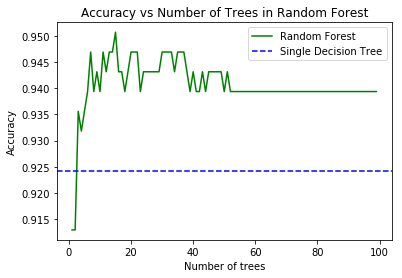

In [25]:
plt.plot(range(1,100), partial_rf_accuracy, c = 'g', label = "Random Forest")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.axhline(dt_accuracy, c = 'b', linestyle = '--', label = "Single Decision Tree") # from decision tree
plt.legend()
plt.title("Accuracy vs Number of Trees in Random Forest")
plt.show()